<h1>Машинне навчання</h1>
<p>Ю.С. Процик. Курс лекцій</p>
<div align="right"><em>Cформовано на основі <a href="https://mlcourse.ai">відкритого курсу</a> Юрія Кашницького</em></div>

# <center>Тема 10. Аналіз часових рядів за допомогою Python</center>

## План

1. [Рухаємося, згладжуємо і оцінюємо](#1.-Рухаємося,-згладжуємо-і-оцінюємо)
    - [Rolling window estimations](#Rolling-window-estimations-(оцінки-ковзного-вікна))
    - [Експоненціальне згладжування, модель Хольта-Вінтерса](#Експоненціальне-згладжування,-модель-Хольта\-Вінтерса)
    - [Крос-валідація на часових рядах, підбір параметрів](#Крос\-валідація-на-часових-рядах,-підбір-параметрів)
    
    
2. [Економетричний підхід](#2.-Економетричний-підхід)
    - [Стаціонарність](#Стаціонарність)
    
    
3. [Лінійні і не дуже моделі на часових рядах](#3.-Лінійні-і-не-дуже-моделі-на-часових-рядах)

    - [Виділення ознак (Feature exctraction)](#Виділення-ознак-(Feature-exctraction))
    - [Лінійна регресія vs XGBoost](#Лінійна-регресія-vs-XGBoost)

Аналітики даних та інженери-дослідники з машинного навчання постійно стикаються з тими чи іншими задачами, пов'язаними з часовими рядами. Найчастіше виникає питання – а що буде відбуватися з деякими показниками в найближчий день/тиждень/місяць/ін. – скільки гравців встановлять додатки, скільки буде онлайну, як багато дій здійснять користувачі, і так далі. До задачі прогнозування можна підходити по-різному, в залежності від того, якої якості повинен бути прогноз, на який період необхідно його будувати, і, звичайно, як довго потрібно підбирати і налаштовувати параметри моделі для його отримання.

Почнемо з простих методів аналізу і прогнозування – ковзних середніх, згладжувань і їх варіацій.

## 1. Рухаємося, згладжуємо і оцінюємо

Невелике [визначення](https://uk.wikipedia.org/wiki/%D0%A7%D0%B0%D1%81%D0%BE%D0%B2%D0%B8%D0%B9_%D1%80%D1%8F%D0%B4) часового ряду:
> Часовий ряд (англ. time series) – це послідовність значень, що описують протікаючий в часі процес, виміряних в послідовні моменти часу, переважно через рівні проміжки

Таким чином, дані є впорядкованими відносно невипадкових моментів часу, і, отже, на відміну від випадкових вибірок, можуть містити в собі додаткову інформацію, яку ми постараємося витягти.

Імпортуємо потрібні бібліотеки. В основному нам знадобиться модуль [statsmodels](http://statsmodels.sourceforge.net/stable/), в якому реалізовані численні методи статистичного моделювання, в тому числі для часових рядів. Для прихильників R, що перейшли на python, `statsmodels` може здатися дуже рідним, так як підтримує написання формулювань моделей в стилі 'Wage ~ Age + Education'.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Для прикладу візьмемо реальні дані по годинному онлайну гравців в одній з мобільних ігр.

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

dataset = pd.read_csv('../data/hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

### Rolling window estimations (оцінки ковзного вікна)

Почнемо моделювання з наївного припущення – "завтра буде, як вчора", але замість моделі виду $\large\hat{y}_{t} = y_{t-1}$ будемо вважати, що майбутнє значення змінної залежить від середнього $k$ її попередніх значень, а отже, скористаємося **ковзним середнім**.
$$
\large\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}
$$

Реалізуємо цю функцію на python і подивимося на прогноз, побудований за останнім спостережуваним днем (24 години).

In [3]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.Users, 24)

29858.333333333332

На жаль, такий прогноз довгостроковим зробити не вдасться, для отримання передбачення на крок вперед попереднє значення має бути фактично спостережуваною величиною. Зате у ковзного середнього є інше застосування – згладжування вихідного ряду для виявлення трендів (тенденції зміни показників часового ряду), в Pandas є готова реалізація – [`DataFrame.rolling(window).mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html). Чим більшою задамо ширину інтервалу – тим більш плавним виявиться тренд. У разі, якщо дані сильно зашумлені, що особливо часто зустрічається, наприклад, у фінансових показниках, така процедура може допомогти побачити загальні патерни.

In [4]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # За бажання, можна будувати і довірчі інтервали для згладжених значень
    #rolling_std =  series.rolling(window=n).std()
    #upper_bound = rolling_mean+1.96*rolling_std
    #lower_bound = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
    #plt.plot(lower_bound, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

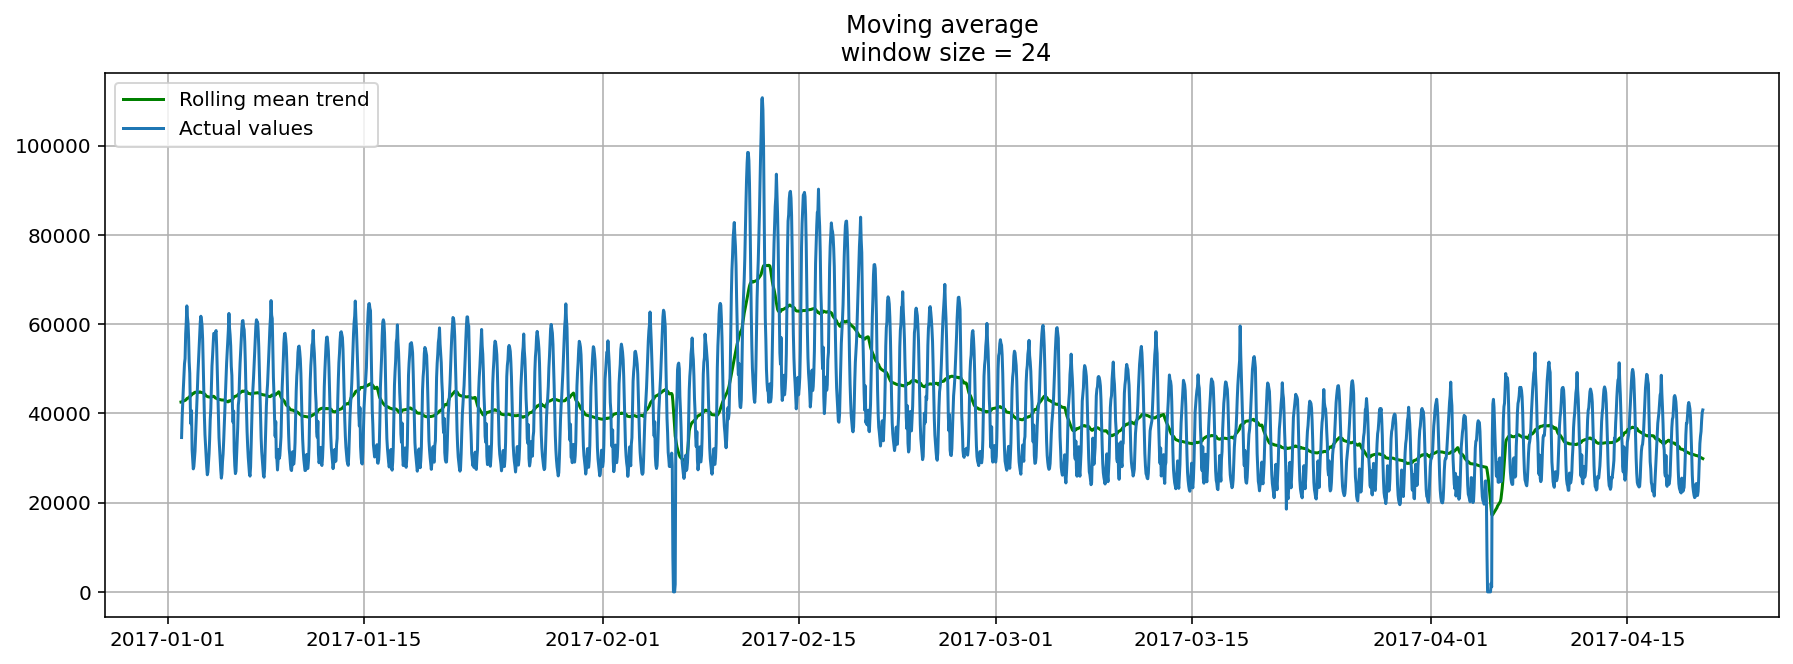

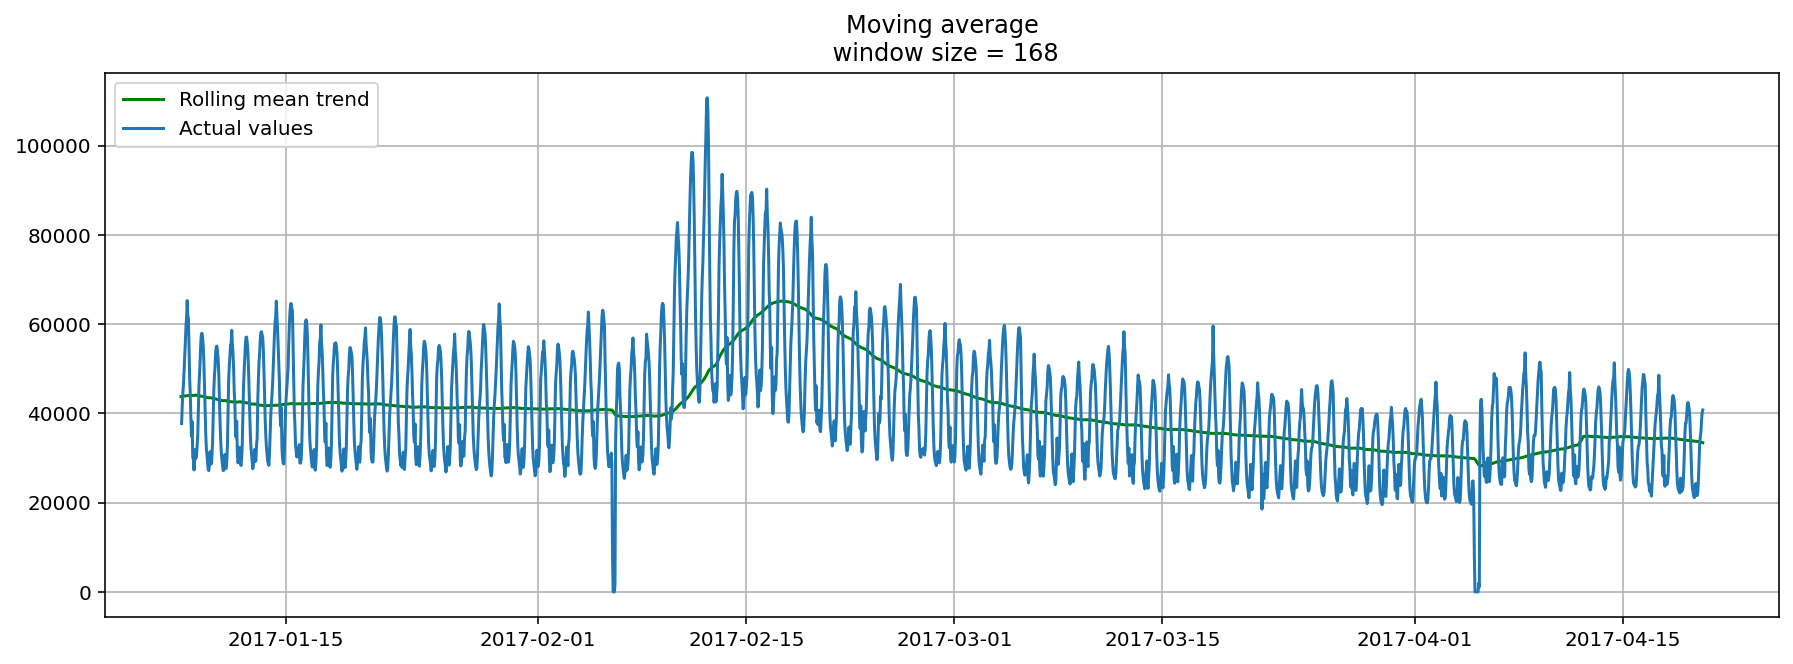

In [5]:
plotMovingAverage(dataset, 24) # згладжуємо по днях
plotMovingAverage(dataset, 24*7) # згладжуємо по тижнях

Для нашого ряду тренди і так цілком очевидні, але якщо згладити по днях, стає краще видно динаміка онлайну по буднях і вихідних (вихідні - час пограти), а тижневе згладжування добре відображає загальні зміни, пов'язані з різким зростанням кількості активних гравців в лютому і подальшим зниженням в березні.

Модифікацією простого ковзного середнього є зважене середнє, всередині якого спостереженням надаються різні ваги, що в сумі дають одиницю, при цьому зазвичай останнім спостереженням присвоюється більша вага.


$$
\large\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}
$$

In [6]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return result

In [7]:
weighted_average(dataset.Users, [0.03, 0.07, 0.1, 0.2, 0.6])

39907.43

### Експоненціальне згладжування, модель Хольта-Вінтерса

#### Експоненціальне згладжування

А тепер подивимося, що станеться, якщо замість зважування останніх $k$ значень ряду ми почнемо зважувати всі доступні спостереження, при цьому експоненціально зменшуючи ваги в міру заглиблення в історичні дані. У цьому нам допоможе формула простого [експоненціального згладжування](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):
$$
\large\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1}
$$

Тут модельне значення представляє собою середньозважене між поточним істинним і попереднім модельним значеннями. Вага $\alpha$ називається згладжуючим фактором і визначає, як швидко ми будемо "забувати" останнє доступне справжнє спостереження. Чим менше $\alpha$, тим більший вплив мають попередні модельні значення, і тим сильніше згладжується ряд.

Експоненціальність ховається в рекурсивності функції – кожен раз ми множимо $(1-\alpha)$ на попереднє модельне значення, яке, в свою чергу, також містило в собі $(1-\alpha)$, і так до самого початку.

In [8]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # перше значення те саме, що і ряд
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

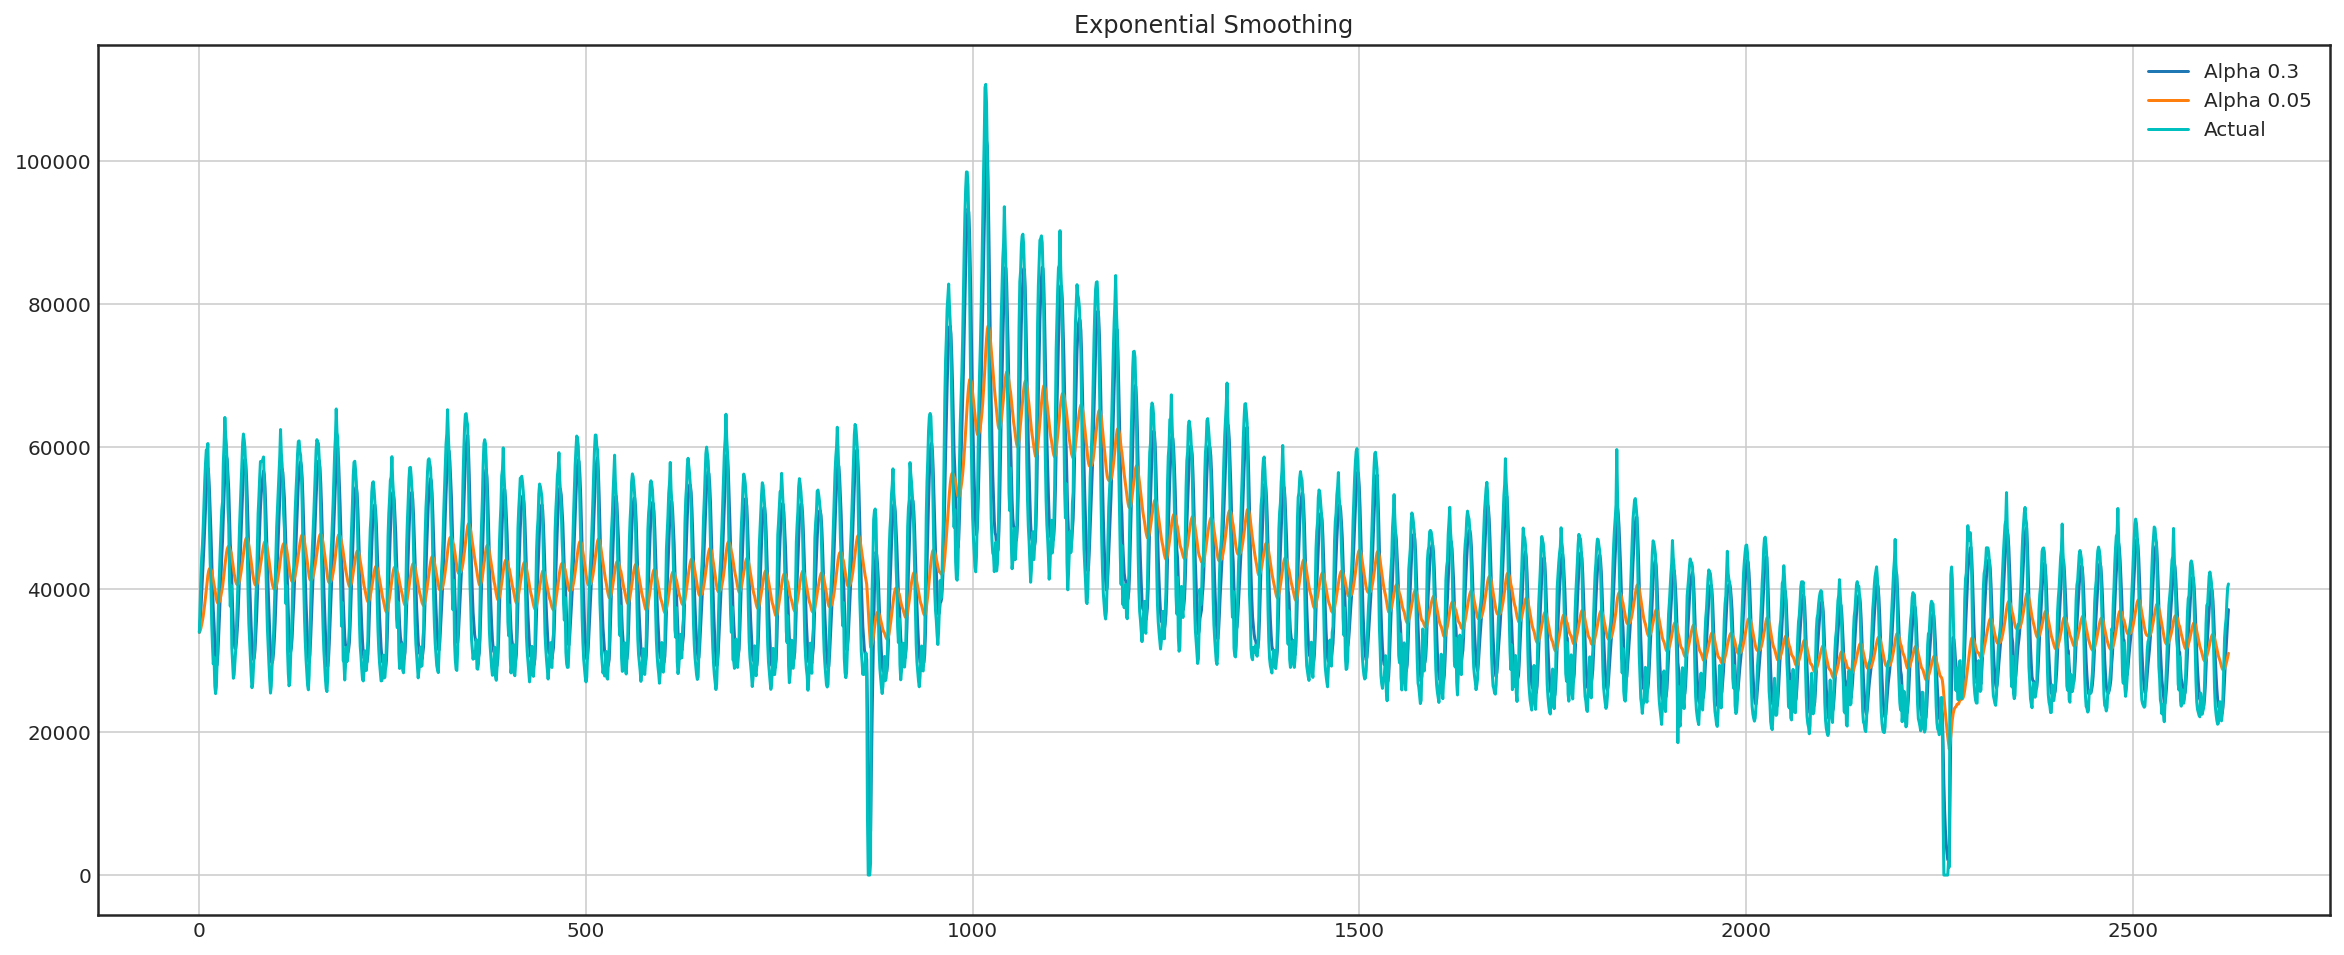

In [9]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Users.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

#### Подвійне експоненціальне згладжування

Досі ми могли отримати від наших методів в кращому випадку прогноз лише на одну точку вперед (і ще красиво згладити ряд). Чудово, але цього недостатньо. Тому переходимо до розширення експоненціального згладжування, яке дозволить будувати прогноз відразу на дві точки вперед (і теж красиво згладжувати ряд).

У цьому нам допоможе розбиття ряду на дві складові – рівень (level, intercept) $\ell$ і тренд $b$ (trend, slope). Рівень, або очікуване значення ряду, ми передбачали за допомогою попередніх методів, а тепер таке ж експоненціальне згладжування застосуємо до тренда, наївно чи не дуже вважаючи, що майбутній напрямок зміни ряду залежить від зважених попередніх змін.

$$\large \ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$\large b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\large \hat{y}_{x+1} = \ell_x + b_x$$

В результаті отримуємо набір функцій. Перша визначає рівень – він, як і раніше, залежить від поточного значення ряду, а другий доданок тепер розбивається на попереднє значення рівня та тренда. Друга відповідає за тренд – він залежить від зміни рівня на поточному кроці, і від попереднього значення тренда. Тут в ролі ваги в експоненціальному згладжуванні виступає коефіцієнт $\beta$. Нарешті, результуюче прогнозування є сумою модельних значень рівня і тренда.

In [10]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозуємо
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

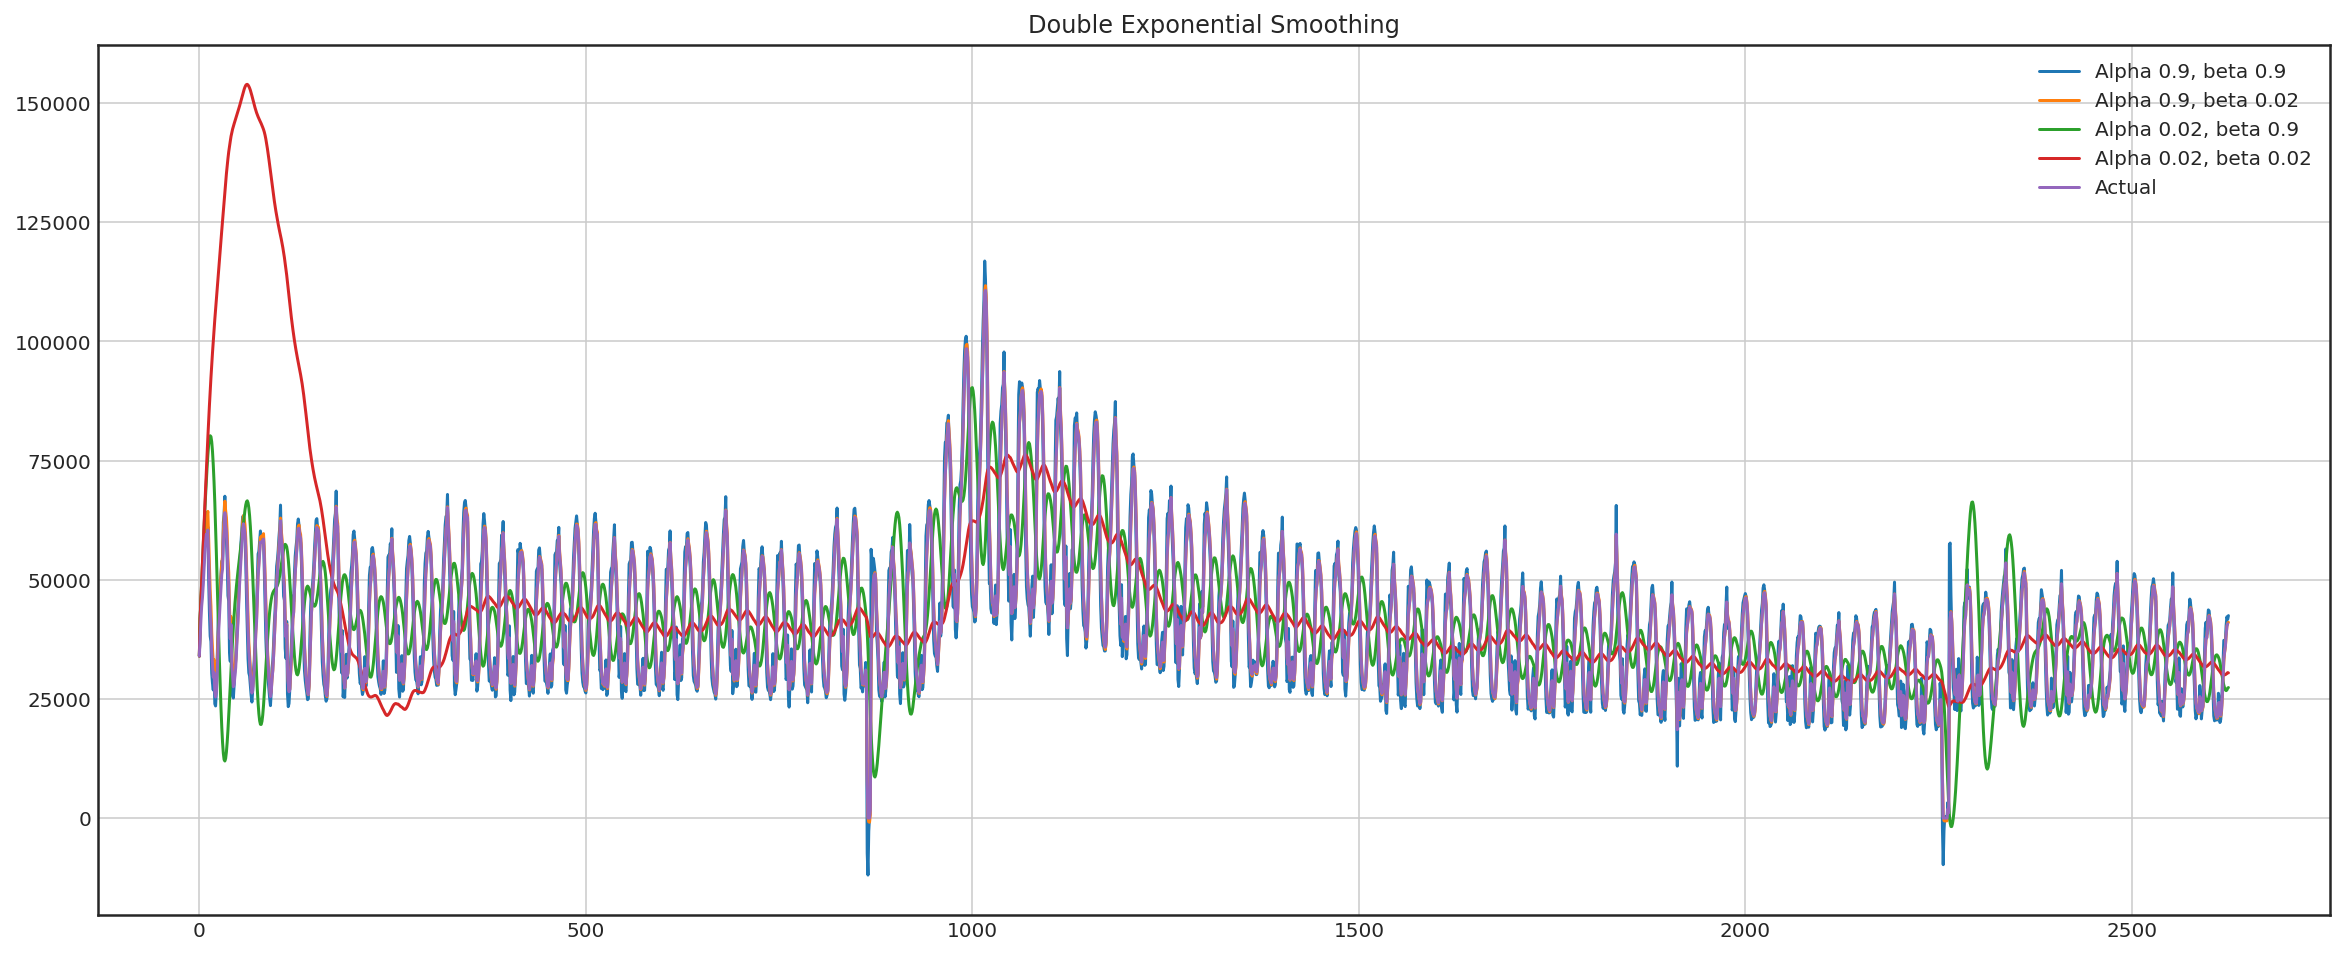

In [11]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Тепер налаштовувати довелося вже два параметра – $\alpha$ і $\beta$. Перший відповідає за згладжування ряду навколо тренда, другий – за згладжування самого тренда. Чим вищі значення, тим більша вага буде надаватися останнім спостереженням і тим менше згладженим буде модельний ряд. Комбінації параметрів можуть видавати досить дивні результати, особливо якщо задавати їх руками. Не ручний підбір параметрів буде описано трохи нижче, одразу після потрійного експоненціального згладжування.

#### Потрійне експоненціальне згладжування (метод Хольта-Вінтерса)

Ідея цього методу полягає в додаванні ще однієї, третьої, компоненти – сезонності. Відповідно, метод можна застосовувати тільки в разі, якщо ряд цієї сезонністю не обділений, що в нашому випадку вірно. Сезонна компонента в моделі буде пояснювати повторювані коливання навколо рівня і тренда, а характеризуватися вона буде довжиною сезону – періодом, після якого починаються повторення коливань. Для кожного спостереження в сезоні формується своя компонента, наприклад, якщо довжина сезону становить 7 (наприклад, тижнева сезонність), то отримаємо 7 сезонних компонент, по штуці на кожен день тижня.

Отримуємо нову систему:

$$\large \ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$\large b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\large s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\large \hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Рівень тепер залежить від поточного значення ряду за вирахуванням відповідної сезонної компоненти, тренд залишається без змін, а сезонна компонента залежить від поточного значення ряду за вирахуванням рівня і від попереднього значення компоненти. При цьому компоненти згладжуються через всі доступні сезони, наприклад, якщо це компонента, що відповідає за понеділок, то і усереднюватися вона буде тільки з іншими понеділками. Детальніше про роботу усереднень і оцінку початкових значень тренда і сезонних компонент можна почитати [тут](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Тепер, маючи сезонну компоненту, ми можемо прогнозувати вже не на один, і навіть не на два, а на довільні $m$ кроків вперед, що не може не радувати.

Нижче наведено код для побудови моделі потрійного експоненціального згладжування, також відомої за прізвищами її творців — Чарльза Хольта і його студента Пітера Вінтерса.
Додатково в модель включено метод Брутлага для побудови довірчих інтервалів:

$$\large \hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\large \hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$\large d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$


де $T$ – довжина сезону, $d$ – передбачене відхилення, а інші параметри беруться з потрійного згладжування. Детальніше про метод і про його застосування до пошуку аномалій у часових рядах можна прочитати [тут](https://fedcsis.org/proceedings/2012/pliks/118.pdf).

In [12]:
class HoltWinters:

    """
    Модель Хольта-Вінтерса з методом Брутлага для виявленння аномалій
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - вихідний часовий ряд
    # slen - довжина сезону
    # alpha, beta, gamma - коефіцієнти моделі Хольта-Вінтерса
    # n_preds - горизонт прогнозувань
    # scaling_factor - задає ширину довірчого інтервалу за Брутлагом (зазвичай приймає значення від 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # обчислюємо сезонні середні
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # обчислюємо початкові значення
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # ініціалізуємо значення компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBound.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBound.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозуємо
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # під час прогнозування з кожним кроком збільшуємо невизначеність
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Відхилення розраховується відповідно до алгоритму Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBound.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBound.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

### Крос-валідація на часових рядах, підбір параметрів

Перед тим, як побудувати модель, поговоримо, нарешті, про не ручний спосіб оцінки параметрів для моделей.

Нічого незвичайного тут немає, як і раніше спочатку необхідно вибрати прийнятну для даної задачі функцію втрат: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error), [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) і ін., яка буде стежити за якістю підгонки моделі під вихідні дані. Потім будемо оцінювати на крос-валідації значення функції втрат при даних параметрах моделі, шукати градієнт, змінювати відповідно до нього параметри і рухатися в напрямку глобального мінімуму помилки.

Невелика проблема виникає тільки в крос-валідації. Проблема полягає в тому, що часовий ряд має, як не парадоксально, часову структуру, і випадково перемішувати значення всього ряду без збереження цієї структури не можна, інакше в процесі загубляться всі взаємозв'язки спостережень. Тому доведеться використовувати трохи більш хитрий спосіб для оптимізації параметрів, для якого на сайті [CrossValidated](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection) пропонують назву "cross-validation on a rolling basis", що не дослівно можна перекласти як крос-валідація на ковзному вікні.

Суть досить проста – починаємо навчати модель на невеликому відрізку часового ряду, від початку до деякого $t$, робимо прогноз на $t+n$ кроків вперед і обчислюємо помилку. Далі розширюємо навчальну вибірку до $t+n$ значення і прогнозуємо з $t+n$ до $t+2*n$, так продовжуємо рухати тестовий відрізок ряду до тих пір, поки не досягнемо останнього доступного спостереження. В результаті отримаємо стільки фолдів (частин), скільки $n$ вміститься в проміжок між початковим навчальним відрізком і всією довжиною ряду.

<img src="../img/cv_rolling_basis.png"/>

In [13]:
# Код для крос-валідації на часовому ряді

from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор помилок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаємо кількість частин для крос-валідації
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # йдемо по частинах, на кожній навчаємо модель, будуємо прогноз на відкладеній вибірці і обчислюємо помилку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

Значення довжини сезону 24\*7 виникло не випадково – в вихідному ряді чітко видно денну сезонність, (звідси 24), і тижневу – по буднях нижче, на вихідних – вище, (звідси 7), сумарно сезонних компонент вийде 24\*7.

В моделі Хольта-Вінтерса, як і в інших моделях експоненціального згладжування, є обмеження на величину згладжуючих параметрів – кожен з них може приймати значення від 0 до 1, тому для мінімізації функції втрат потрібно вибирати алгоритм, що підтримує обмеження на параметри, в даному випадку – Truncated Newton conjugate gradient.

In [14]:
%%time
data = dataset.Users[:-500] # відкладемо частину даних для тестування

# ініціалізуємо значення параметрів
x = [0, 0, 0] 

# мінімізуємо функцію втрат з обмеженнями на параметри
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# з оптимізатора беремо оптимальне значення параметрів
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006635880294816432 0.0 0.046569454900318885
Wall time: 38.3 s


Передамо отримані оптимальні значення коефіцієнтів $\alpha$, $\beta$ і $\gamma$ і побудуємо прогноз на 5 днів вперед (120 годин)

In [15]:
# Передаємо оптимальні значення моделі 
data = dataset.Users
model = HoltWinters(data[:-120], slen = 24*7, 
                    alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 120, scaling_factor = 2.56)
model.triple_exponential_smoothing()

Код для відтворення графіка

In [16]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBound] = data.values[data.values<model.LowerBound]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBound, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBound, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBound, y2=model.LowerBound, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-120, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

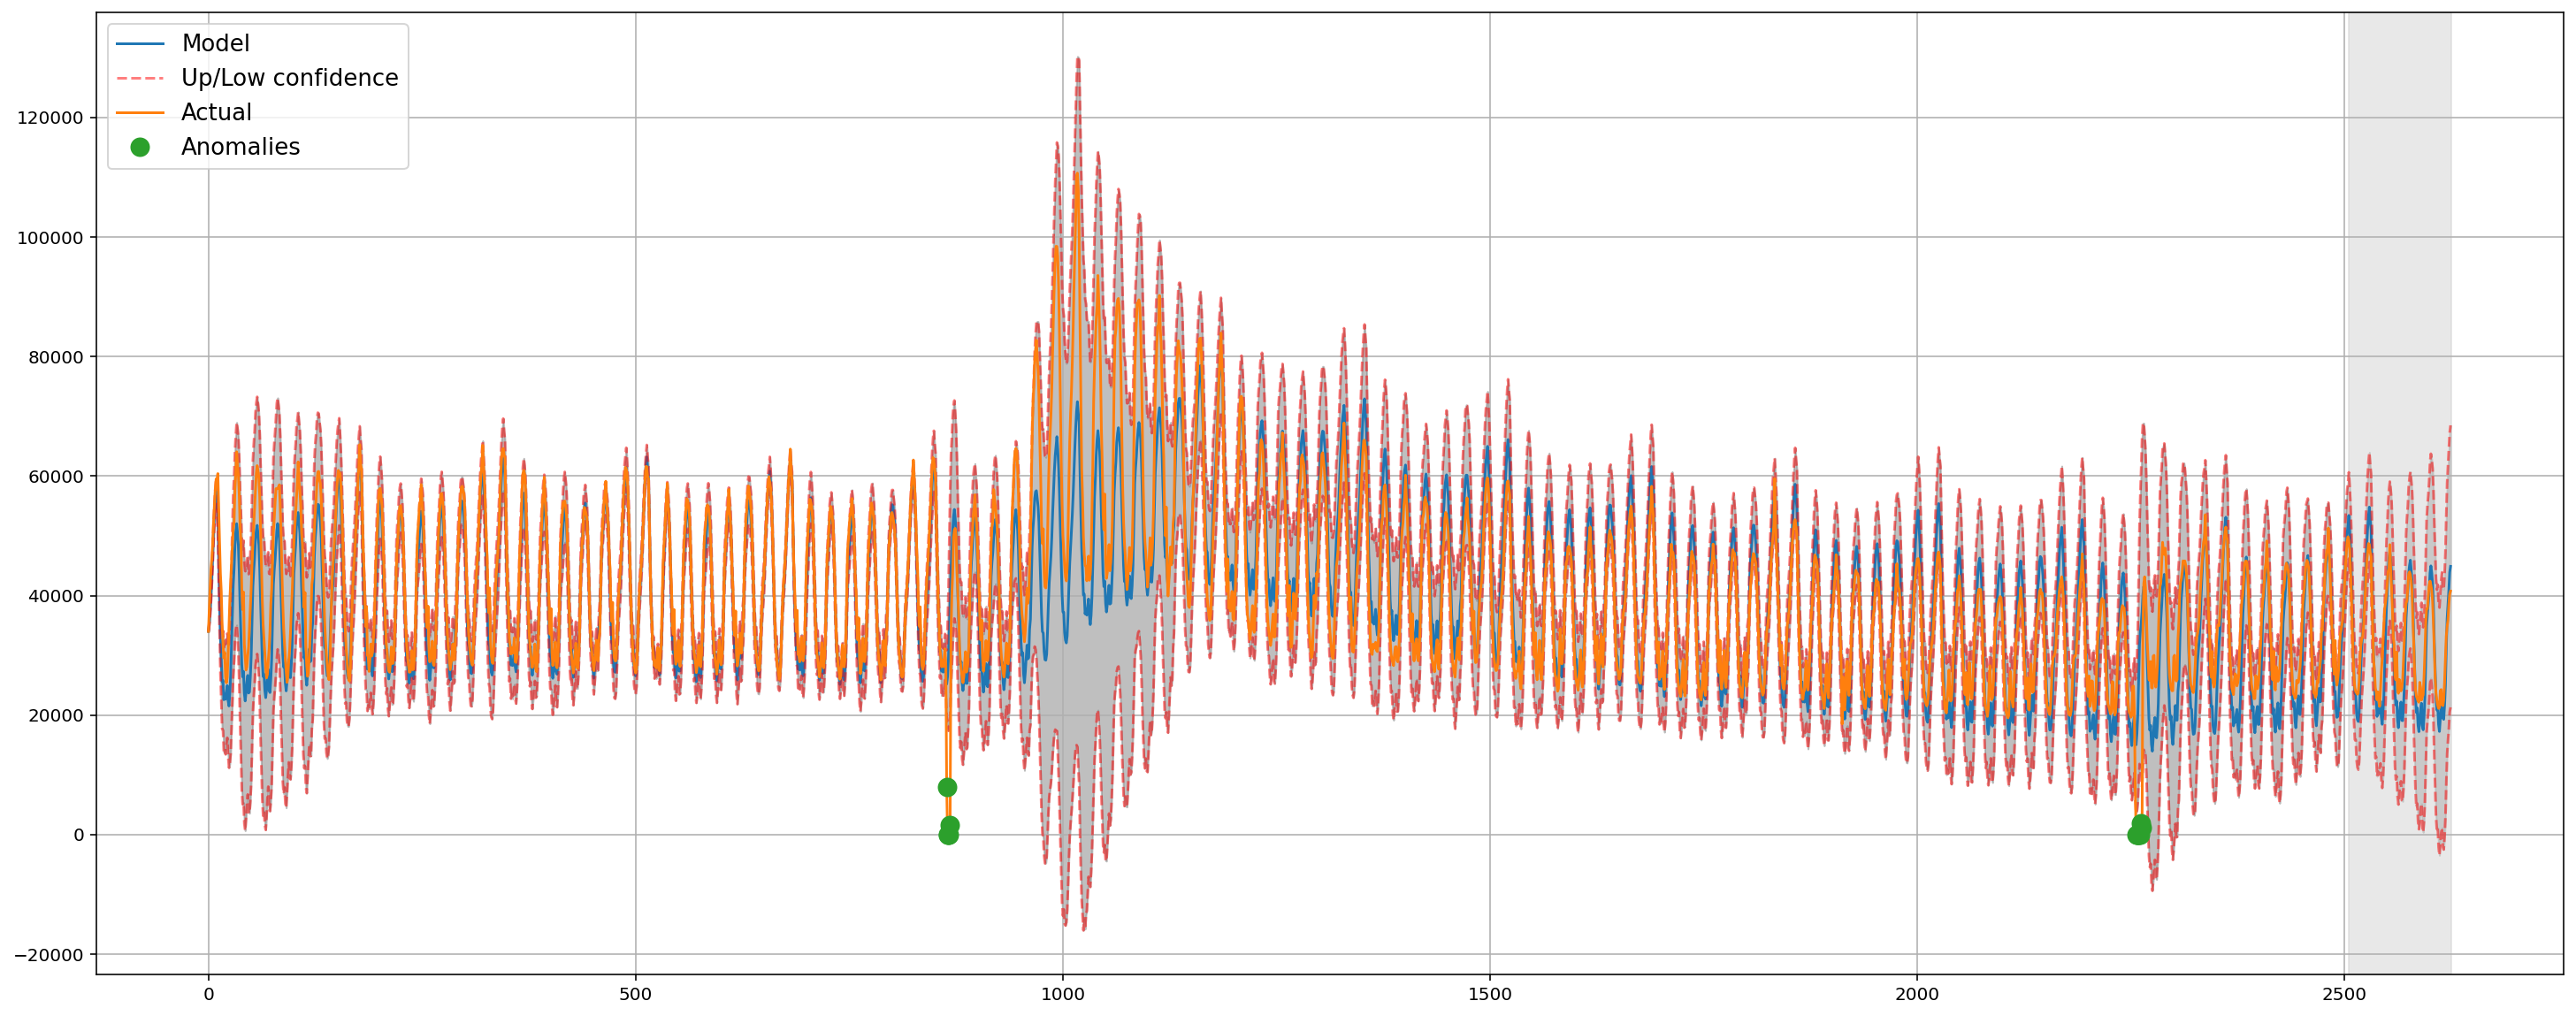

In [17]:
plotHoltWinters()

Судячи з графіку, модель непогано описала вихідний часовий ряд, вловивши тижневу і денну сезонність, і навіть змогла зловити аномальні зниження, що вийшли за межі довірчих інтервалів. Якщо подивитися на змодельоване відхилення, добре видно, що модель досить різко реагує на значні зміни в структурі ряду, але при цьому швидко повертає дисперсію до звичайних значень, "забуваючи" минуле. Така особливість дозволяє непогано і без значних витрат на підготовку-навчання моделі налаштувати систему з детектування аномалій навіть в досить шумних рядах.

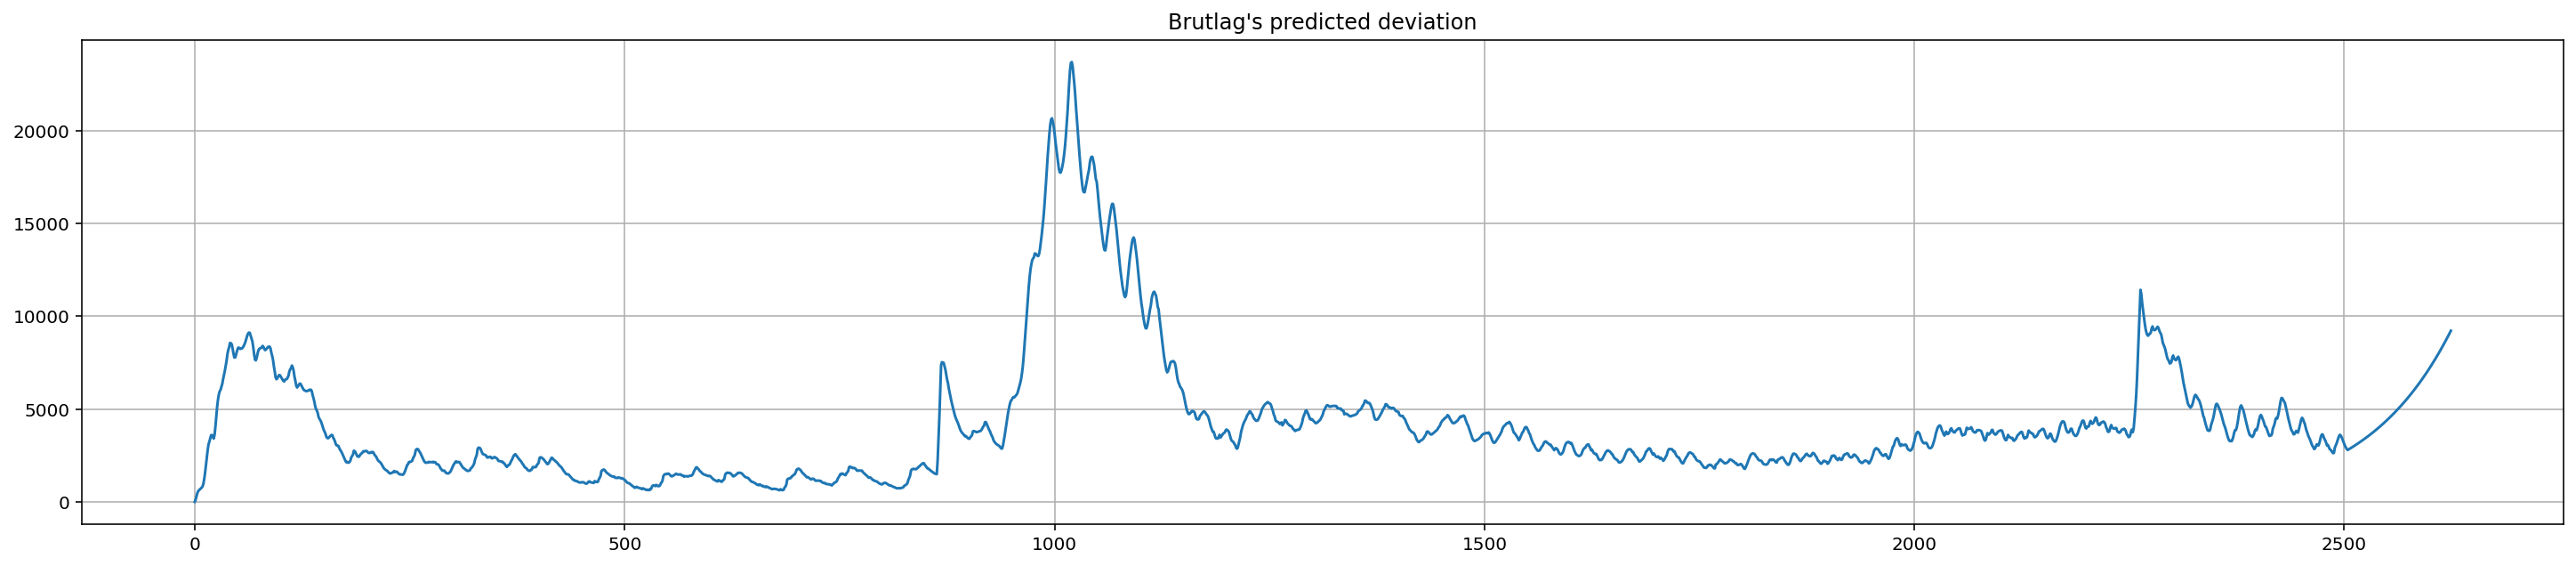

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## 2. Економетричний підхід

### Стаціонарність

Перед тим, як перейти до моделювання, варто сказати про таку важливу властивість часового ряду, як [**стаціонарність**](https://uk.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D1%86%D1%96%D0%BE%D0%BD%D0%B0%D1%80%D0%BD%D1%96%D1%81%D1%82%D1%8C).
Під стаціонарністю розуміють властивість процесу не міняти своїх статистичних характеристик з часом, а саме сталість математичного сподівання, сталість дисперсії (вона ж [гомоскедастичність](https://uk.wikipedia.org/wiki/%D0%93%D0%BE%D0%BC%D0%BE%D1%81%D0%BA%D0%B5%D0%B4%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D1%96%D1%81%D1%82%D1%8C)) і незалежність коваріаційної функції від часу (повинна залежати тільки від відстані між спостереженнями). Наочно можна подивитися на ці властивості на картинках, взятих з поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Часовий ряд справа не є стаціонарним, так як його математичне сподівання з часом зростає

<img src="../img/series01.png"/>

- Тут не пощастило з дисперсією — розкид значень ряду істотно варіюється в залежності від періоду

<img src="../img/series02.png"/>

- Нарешті, на останньому графіку видно, що значення ряду раптово стають ближчими один до одного, утворюючи деякий кластер, а в результаті отримуємо несталість коваріацій

<img src="../img/series03.png"/>

Чому стаціонарність настільки важлива? По стаціонарному ряду просто будувати прогноз, так як ми вважаємо, що його майбутні статистичні характеристики не будуть відрізнятися від спостережуваних поточних. Більшість моделей часових рядів так чи інакше моделюють і передбачають ці характеристики (наприклад, математичне сподівання або дисперсію), тому в разі нестаціонарності вихідного ряду передбачення виявляться невірними. На жаль, більшість часових рядів, з якими доводиться стикатися за межами навчальних матеріалів, стаціонарними не є, але з цим можна (і потрібно) боротися.

Щоб боротися з нестаціонарністю, потрібно вміти її розпізнавати, тому подивимося, як її детектувати. Для цього звернемося до білого шуму і випадкового блукання.

Графік білого шуму:

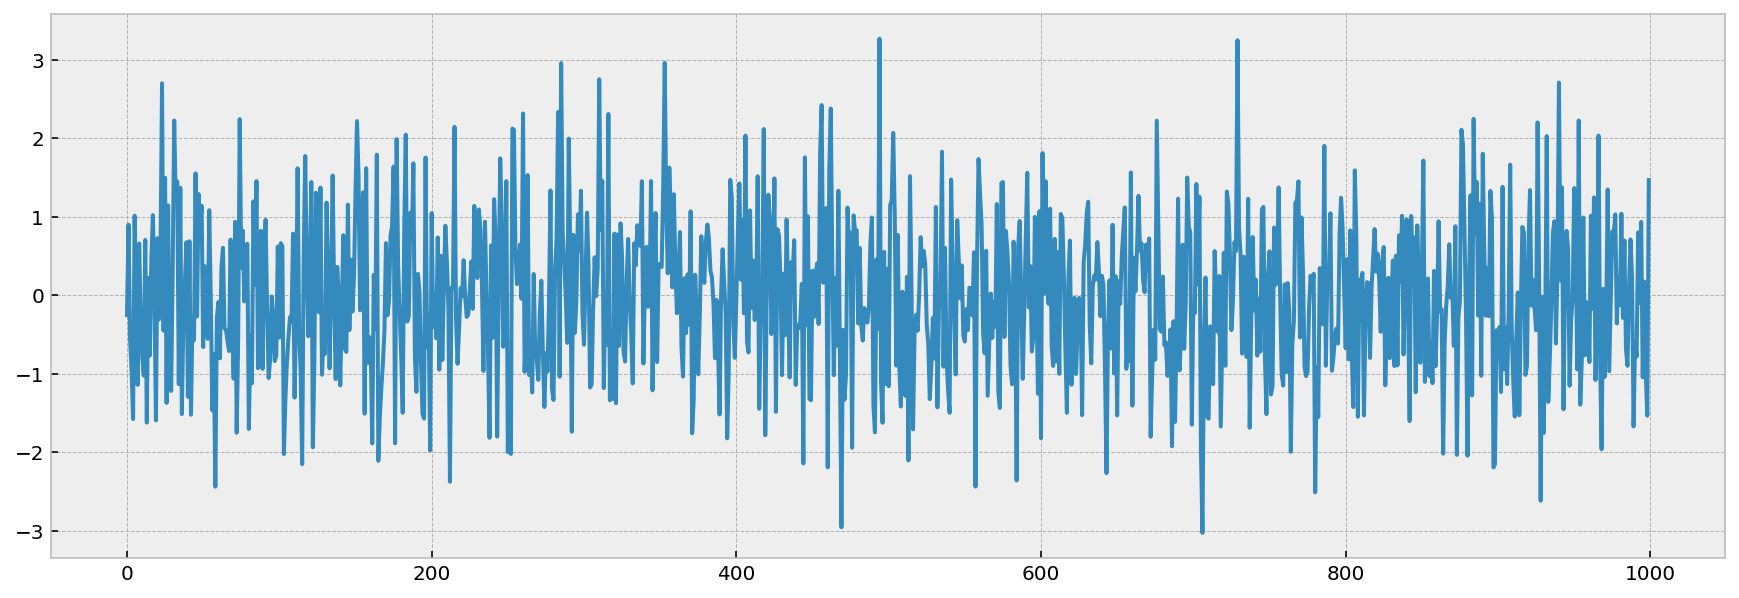

In [19]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Отже, процес, породжений стандартним нормальним розподілом є стаціонарним, коливається навколо нуля з відхиленням 1. Тепер на його основі згенеруємо новий процес, в якому кожне наступне значення буде залежати від попереднього: $\large x_t = \rho x_{t-1} + e_t$

Код для відтворення графіків

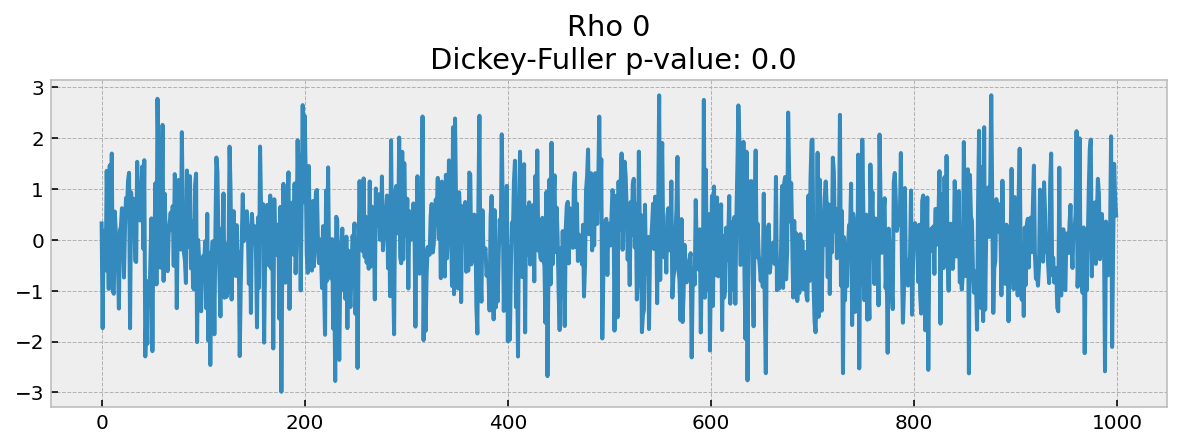

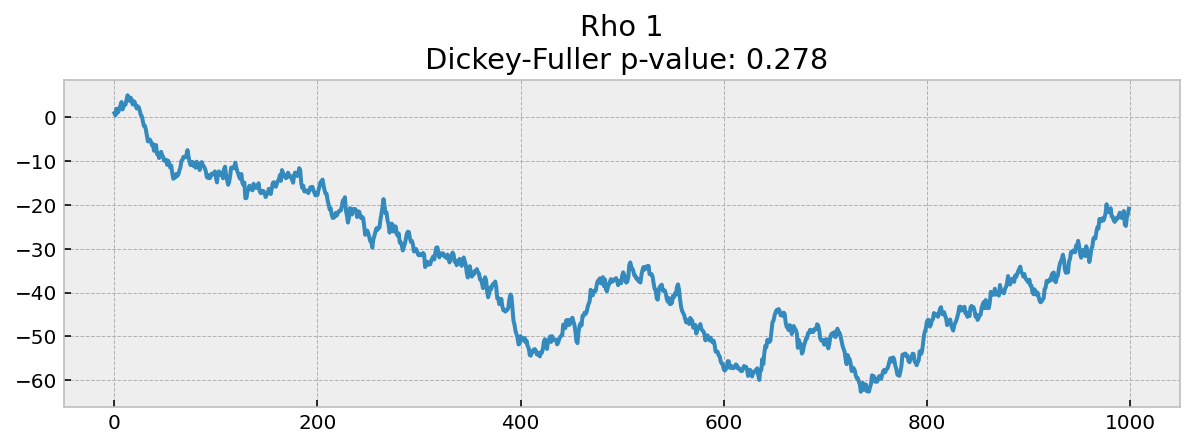

In [20]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На першому графіку вийшов такий самий стаціонарний білий шум, який будувався раніше. На другому значення $\rho$ збільшилося до 0.6, в результаті чого на графіку стали з'являтися більш широкі цикли, але в цілому стаціонарним він бути поки не перестав. Третій графік все сильніше відхиляється від нульового середнього значення, але все ще коливається навколо нього. Нарешті, значення $\rho$ рівне одиниці дало процес випадкового блукання — ряд нестаціонарний.

Відбувається це через те, що при досягненні критичної одиниці, ряд $\large x_t = \rho x_{t-1} + e_t$ перестає повертатися до свого середнього значення. Якщо відняти від лівої і правої частини $x_{t-1}$, то отримаємо $\large x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, де вираз зліва — перші різниці. Якщо $\rho=1$, то перші різниці дадуть стаціонарний білий шум $e_t$. Цей факт ліг в основу тесту [Дікі-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера) на стаціонарність ряду (наявність одиничного кореня). Якщо з нестаціонарного ряду першими різницями вдається отримати стаціонарний, то він називається інтегрованим першого порядку.
Нульова гіпотеза — ряд не є стаціонарним, відкидалася на перших трьох графіках, і була прийнята на останньому. Варто сказати, що не завжди для отримання стаціонарного ряду вистачає перших різниць, так як процес може бути інтегрованим з більш високим порядком (мати кілька одиничних коренів), для перевірки таких випадків використовують розширений тест Дікі-Фуллера, що перевіряє зразу декілька лагів. Лаги — це зсув даних на один крок або більше назад в часі.

Боротися з нестаціонарністю можна багатьма способами — різницями різного порядку, виділенням тренда і сезонності, згладжуваннями і перетвореннями, наприклад, Бокса-Кокса або логарифмуванням.

## 3. Лінійні і не дуже моделі на часових рядах

Часто доводиться будувати моделі, керуючись принципом – "швидко, якісно, недорого". Тому частина моделей можуть банально не підійти, так як або вимагають занадто великих витрат з підготовки даних, або складно налаштовуються, або вимагають частого перенавчання на нових даних, тому нерідко набагато простіше буває виділити кілька ознак з наявного часового ряду і побудувати звичайну лінійну регресію або ліс дерев рішень.

Можливо, цей підхід не надто сильно підкріплений теорією, порушує різні передумови, наприклад, умови Гаусса-Маркова, особливо пункт про некорельованість помилок, однак на практиці нерідко виручає і досить активно використовується в змаганнях по машинному навчанню.

### Виділення ознак (Feature exctraction)

Крім стандартних ознак типу лагів цільової змінної, багато інформації містять в собі дата і час. Про виділення з них ознак вже достатньо багато було сказано в одній з попередніх лекцій курсу.

Додамо тільки про ще один варіант кодування категоріальних ознак – кодування середнім. Якщо не хочеться "роздувати" датасет великою кількістю dummy-змінних, які можуть призвести до втрати інформації про відстані, а в дійснозначному вигляді виникають суперечливі результати типу "0 годин < 23 години", то можна закодувати змінну трохи більше інтерпретованими значеннями. Природний варіант – закодувати середнім значенням цільової змінної. У нашому випадку кожен день тижня або годину дня можна закодувати відповідним середнім числом гравців, які перебували в цей день тижня або годину онлайн. При цьому важливо стежити за тим, щоб розрахунок середнього значення проводився тільки в рамках тестового датасета (або в рамках поточної спостережуваної частини при крос-валідації), інакше можна внести в модель інформацію про майбутнє.

In [21]:
def code_mean(data, cat_feature, real_feature):
    """
    Повертає словник, де ключами є унікальні категорії ознаки cat_feature,
    а значеннями - середні по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Створимо новий датафрейм і додамо в нього годину, день тижня і вихідний в якості категоріальних змінних. Для цього переведемо наявний в датафреймі індекс у формат `datetime`, і витягнемо з нього `hour` і `weekday`.

In [22]:
data = pd.DataFrame(dataset.copy())
data.columns = ["y"]

data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

y  hour  weekday  is_weekend
Time                                                 
2017-01-01 00:00:00  34002     0        6           1
2017-01-01 01:00:00  37947     1        6           1
2017-01-01 02:00:00  41517     2        6           1
2017-01-01 03:00:00  44476     3        6           1
2017-01-01 04:00:00  46234     4        6           1

Подивимося на середні по днях тижня

In [23]:
code_mean(data, 'weekday', "y")

{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

Крім перерахованих перетворень для збільшення кількості ознак використовують і інші метрики, наприклад, максимальне/мінімальне значення, що спостерігалося в ковзному по ряду вікні, медіани, кількість піків, зважені дисперсії і багато іншого. Автоматично цим займається вже згадувана в курсі [бібліотека tsfresh](https://github.com/blue-yonder/tsfresh).
<img src="https://raw.githubusercontent.com/blue-yonder/tsfresh/main/docs/images/introduction_ts_exa_features.png" width=80%>

Для зручності всі перетворення можна записати в одну функцію, яка відразу ж буде повертати розбиті на навчальні і тестові частини дані і цільові змінні.

In [24]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # обчислюємо індекс в датафреймі, після якого починається тестовий відрізок
    test_index = int(len(data)*(1-test_size))
    
    # додаємо лаги вихідного ряду в якості ознак
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # обчислюємо середні тільки по навчальній частині
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # вилучаємо ознаки, що закодовані середніми 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # розбиваємо весь датасет на навчальну і тестову вибірки
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

### Лінійна регресія vs XGBoost

Навчимо на одержаних даних просту лінійну регресію. При цьому лаги будемо брати починаючи з дванадцятого, таким чином модель буде здатна будувати прогноз на 12 годин вперед, маючи фактичні спостереження за попередні пів дня.

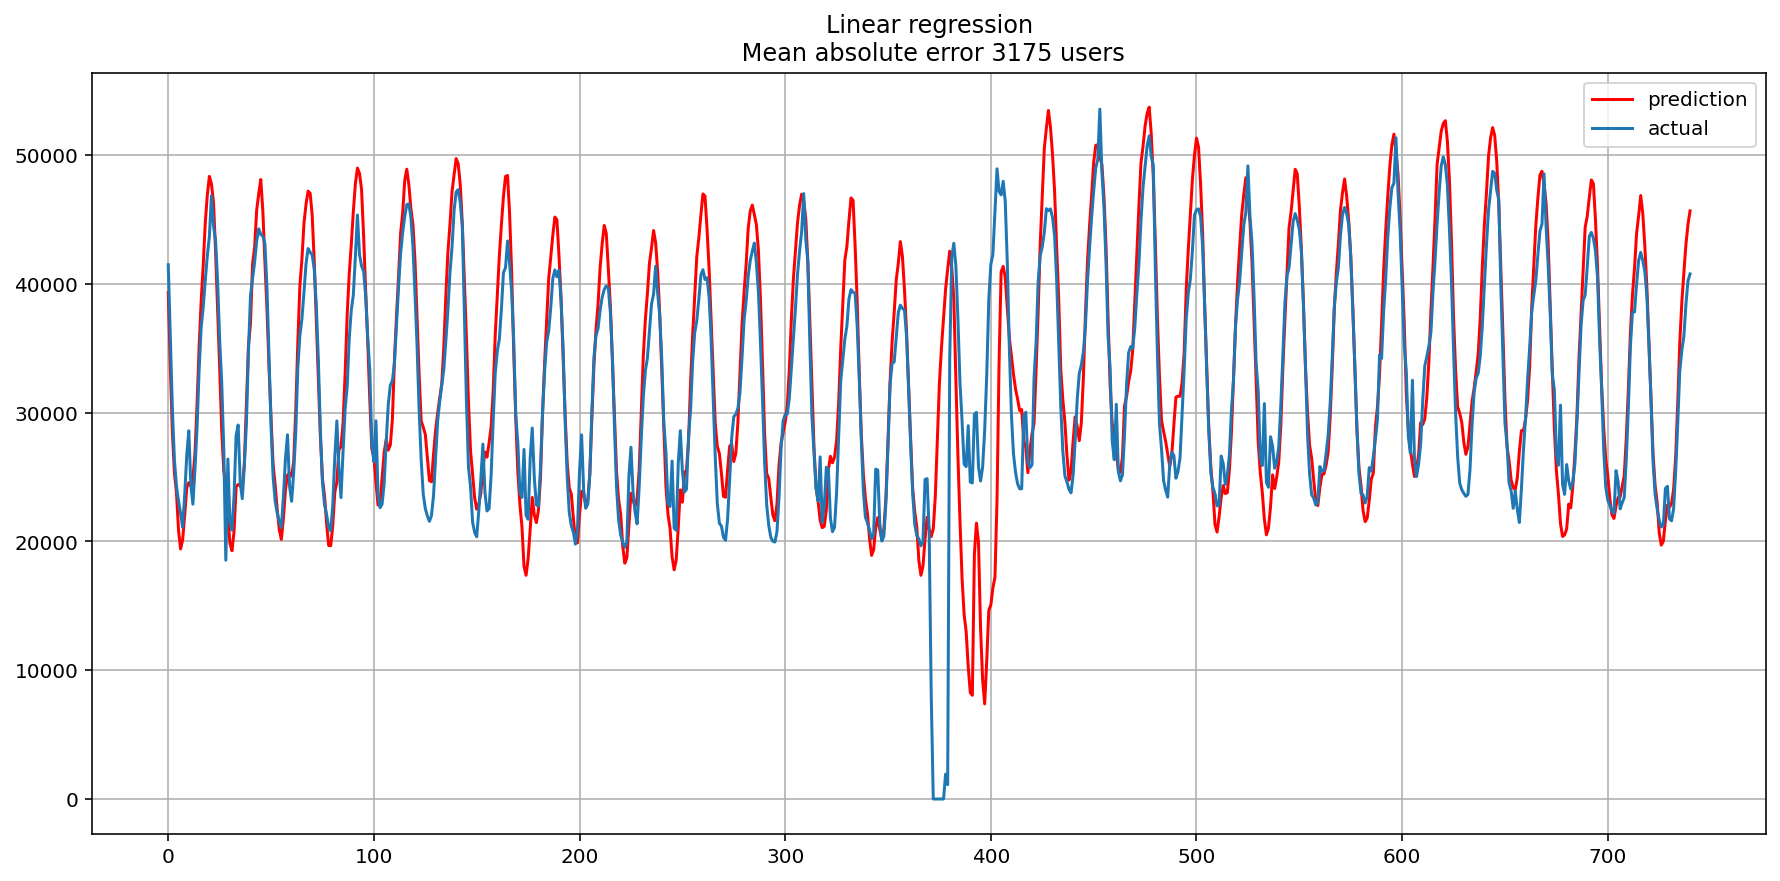

In [25]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(dataset.Users, test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

Вийшло досить непогано, навіть без відбору ознак модель помиляється, в середньому, на 3K користувачів на годину, і це враховуючи величезний викид в середині тестового ряду.

Також можна провести оцінку моделі на крос-валідації, за тим же принципом, що був використаний раніше. Для цього скористаємося функцією (з невеликими модифікаціями), запропонованою в пості [Pythonic Cross Validation on Time Series](http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/)

In [26]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print()
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    
    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [27]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1838, 39)
Size of each fold: 367

Splitting the first 2 chunks at 1/2
Size of train + test: (734, 39)

Splitting the first 3 chunks at 2/3
Size of train + test: (1101, 39)

Splitting the first 4 chunks at 3/4
Size of train + test: (1468, 39)

Splitting the first 5 chunks at 4/5
Size of train + test: (1835, 39)


4613.178931508869

На 5 частинах (фолдах) отримали середню абсолютну помилку в 4.6K користувачів, досить близько до оцінки якості, отриманої на тестовому датасеті.

Спробуємо тепер XGBoost.

In [28]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # вихідні дані
    X_train, X_test, y_train, y_test = prepareData(dataset.Users, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаємо параметри
    params = {
        'objective': 'reg:squarederror',
        'booster':'gblinear'
    }
    trees = 1000

    # проганяємо на крос-валідації з метрикою rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # навчаємо xgboost з оптимальною кількістю дерев, підібраною на крос-валідації
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # запам'ятовуємо помилку на крос-валідації
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # подивимося, як модель вела себе на навчальному відрізку ряду
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # і на тестовому
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bound / lower bound")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

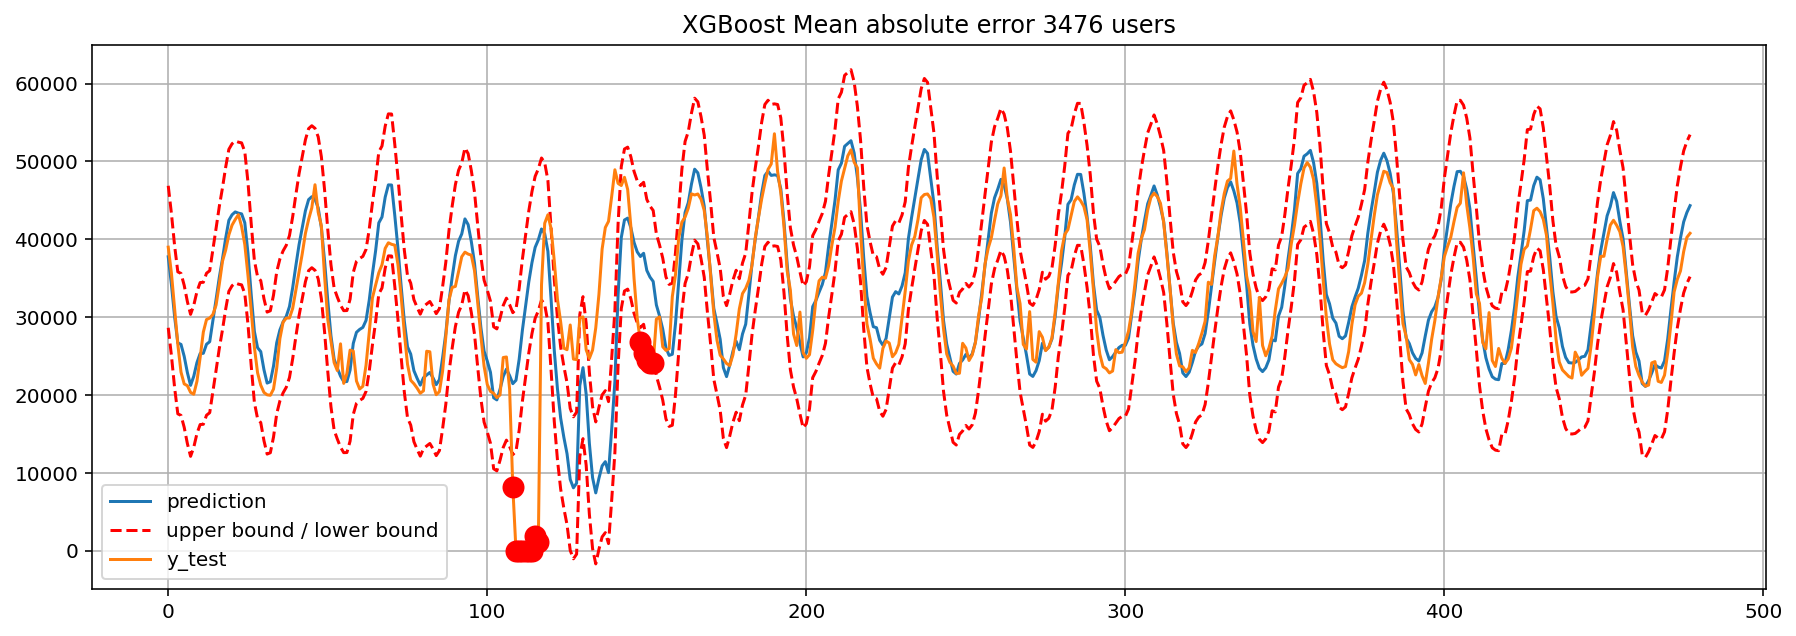

In [29]:
XGB_forecast(dataset, test_size=0.2, lag_start=12, lag_end=48)

Ті ж 3K користувачів в середній абсолютній помилці, і непогано спіймані аномалії на тестовому датасеті. Звичайно, щоб зменшити помилку, ще можна повозитися з параметрами, налаштувати при необхідності регуляризацію, відібрати ознаки, зрозуміти, на скільки лагів потрібно йти вглиб історії і т.д.

Задача прогнозування, як і будь-яка інша задача, яка виникає в процесі роботи з даними – багато в чому творча і вже точно дослідницька. Незважаючи на велику кількість формальних метрик якості та способів оцінки параметрів, для кожного часового ряду часто доводиться підбирати і пробувати щось своє. Не останню роль відіграє і баланс між якістю і трудовитратами. 